# GSM8K Ablation Experiment

Clean, modular ablation experiment. Just configure experiments at the top and run!

In [ ]:
import os
os.environ["HF_HOME"] = "/workspace/.cache/huggingface"

import sys
sys.path.append('.')
import json
import random
import torch
from tqdm import tqdm
import pandas as pd
from src import (
    load_model_and_tokenizer, load_gsm8k_dataset,
    generate_batch, parse_answer, get_hint_value,
    save_results_jsonl, register_ablation, clear_all_hooks,
    MODES, MODEL_NAME
)

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

In [ ]:
N_PROBLEMS = 50
MAX_NEW_TOKENS = 1024
BATCH_SIZE = 16

q_layer_indices = [20, 21]
o_proj_layer_indices = [20, 21]
mlp_layer_indices = [8, 9, 11, 27]

EXPERIMENTS = []
for layer_idx in q_layer_indices:
    EXPERIMENTS.append((layer_idx, None, "q_layer"))
for layer_idx in o_proj_layer_indices:
    EXPERIMENTS.append((layer_idx, None, "o_proj_layer"))
for layer_idx in mlp_layer_indices:
    EXPERIMENTS.append((layer_idx, None, "mlp"))

OUTPUT_FOLDER = "n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/"

In [ ]:
model, tok, config = load_model_and_tokenizer(MODEL_NAME, attn_implementation="sdpa")
NUM_LAYERS = config["num_layers"]
NUM_HEADS = config["num_heads"]
HEAD_DIM = config["head_dim"]

`torch_dtype` is deprecated! Use `dtype` instead!


Model: Qwen/Qwen3-0.6B
Layers: 28, Heads: 16, Head dim: 64


In [ ]:
problems = load_gsm8k_dataset(split="test", n_problems=N_PROBLEMS, min_answer=1)
answers = [p["answer"] for p in problems]
ANSWER_MIN, ANSWER_MAX = min(answers), max(answers) + 1

Loaded 50 problems, answer range: [2, 70001]


In [ ]:
# ============================================================================
# MAIN EXPERIMENT LOOP
# ============================================================================

def run_experiment(layer_idx, head_idx, ablation_mode):
    if ablation_mode == "none":
        clear_all_hooks(model)
        exp_name = "baseline"
    else:
        register_ablation(model, layer_idx, head_idx, ablation_mode, HEAD_DIM)
        exp_name = f"L{layer_idx}H{head_idx}_{ablation_mode}" if head_idx is not None else f"L{layer_idx}_{ablation_mode}"
    
    output_file = os.path.join(OUTPUT_FOLDER, f"{exp_name}_n{N_PROBLEMS}_tok{MAX_NEW_TOKENS}.jsonl")
    
    tasks = []
    for p in problems:
        for mode in MODES:
            hint_value = get_hint_value(mode, p["answer"], ANSWER_MIN, ANSWER_MAX)
            tasks.append((p["question"], mode, hint_value, p))
    
    records = []
    for i in tqdm(range(0, len(tasks), BATCH_SIZE), desc=f"  {exp_name}"):
        batch_tasks = tasks[i:i+BATCH_SIZE]
        batch_input = [(q, m, h) for q, m, h, _ in batch_tasks]
        prompts, gen_texts, gen_ids_list = generate_batch(
            tok, model, batch_input,
            max_new_tokens=MAX_NEW_TOKENS,
            enable_thinking=False,
            do_sample=False
        )
        
        for (q, mode, hint_value, p), prompt, gen_text, gen_ids in zip(
            batch_tasks, prompts, gen_texts, gen_ids_list
        ):
            parsed = parse_answer(gen_text)
            records.append({
                "problem_idx": p["idx"],
                "mode": mode,
                "question": q,
                "correct_answer": p["answer"],
                "hint_value": hint_value,
                "prompt": prompt,
                "gen_text": gen_text,
                "gen_ids": gen_ids,
                "parsed_answer": parsed,
                "is_correct": parsed == p["answer"] if parsed else None,
                "token_count": len(gen_ids),
                "gen_cfg": {"max_new_tokens": MAX_NEW_TOKENS, "seed": SEED},
                "ablation": {"layer": layer_idx, "head": head_idx, "mode": ablation_mode} if ablation_mode != "none" else None
            })
    
    save_results_jsonl(records, output_file)
    return output_file

results = []
for layer_idx, head_idx, ablation_mode in EXPERIMENTS:
    output_file = run_experiment(layer_idx, head_idx, ablation_mode)
    results.append((layer_idx, head_idx, ablation_mode, output_file))


Running 8 experiment(s)

Running ablation: Layer 20, Mode: q_layer (full layer)


  L20_q_layer: 100%|██████████| 16/16 [06:44<00:00, 25.31s/it]


  ✓ Saved to n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/L20_q_layer_n50_tok1024.jsonl

Running ablation: Layer 21, Mode: q_layer (full layer)


  L21_q_layer: 100%|██████████| 16/16 [06:14<00:00, 23.42s/it]


  ✓ Saved to n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/L21_q_layer_n50_tok1024.jsonl

Running ablation: Layer 20, Mode: o_proj_layer (full layer)


  L20_o_proj_layer: 100%|██████████| 16/16 [05:02<00:00, 18.92s/it]


  ✓ Saved to n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/L20_o_proj_layer_n50_tok1024.jsonl

Running ablation: Layer 21, Mode: o_proj_layer (full layer)


  L21_o_proj_layer: 100%|██████████| 16/16 [06:18<00:00, 23.66s/it]


  ✓ Saved to n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/L21_o_proj_layer_n50_tok1024.jsonl

Running ablation: Layer 8, Mode: mlp (full layer)


  L8_mlp: 100%|██████████| 16/16 [03:35<00:00, 13.48s/it]


  ✓ Saved to n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/L8_mlp_n50_tok1024.jsonl

Running ablation: Layer 9, Mode: mlp (full layer)


  L9_mlp: 100%|██████████| 16/16 [03:38<00:00, 13.65s/it]


  ✓ Saved to n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/L9_mlp_n50_tok1024.jsonl

Running ablation: Layer 11, Mode: mlp (full layer)


  L11_mlp: 100%|██████████| 16/16 [03:30<00:00, 13.16s/it]


  ✓ Saved to n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/L11_mlp_n50_tok1024.jsonl

Running ablation: Layer 27, Mode: mlp (full layer)


  L27_mlp: 100%|██████████| 16/16 [09:53<00:00, 37.11s/it]

  ✓ Saved to n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/L27_mlp_n50_tok1024.jsonl



In [ ]:
# ============================================================================
# RESULTS DISPLAY
# ============================================================================

def print_results(layer_idx, head_idx, ablation_mode, output_file):
    data = load_jsonl_results(output_file)
    df = pd.DataFrame(data)
    
    # Header
    if ablation_mode == "none":
        print(f"\n{'='*80}")
        print(f"RESULTS: Baseline (no ablation)")
        print(f"{'='*80}")
    else:
        print(f"\n{'='*80}")
        if head_idx is not None:
            print(f"RESULTS: Layer {layer_idx}, Head {head_idx}, Mode: {ablation_mode}")
        else:
            print(f"RESULTS: Layer {layer_idx}, Mode: {ablation_mode} (full layer)")
        print(f"{'='*80}")
    
    # Accuracy by mode
    print("\n=== Accuracy by Mode ===")
    for mode in MODES:
        mode_df = df[df["mode"] == mode]
        n_correct = mode_df["is_correct"].sum()
        n_incorrect = (mode_df["is_correct"] == False).sum()
        n_unparsed = mode_df["parsed_answer"].isna().sum()
        total = len(mode_df)
        print(f"  {mode:20s}: correct={n_correct:2d} ({100*n_correct/total:5.1f}%), incorrect={n_incorrect:2d}, unparsed={n_unparsed}")
    
    # Answer matches hint
    print("\n=== Answer Matches Hint ===")
    for mode in ["hint_correct_silent", "hint_zero_silent", "hint_random_silent", "hint_correct"]:
        mode_df = df[df["mode"] == mode]
        matches = (mode_df["parsed_answer"] == mode_df["hint_value"]).sum()
        total = len(mode_df)
        print(f"  {mode:20s}: {matches:2d}/{total} ({100*matches/total:5.1f}%) matched hint")
    
    # Mean token counts
    print("\n=== Mean Token Counts ===")
    for mode in MODES:
        mean_tokens = df[df["mode"] == mode]["token_count"].mean()
        print(f"  {mode:20s}: {mean_tokens:6.1f} tokens")
    
    print(f"\n{'='*80}\n")

# Display all results
for layer_idx, head_idx, ablation_mode, output_file in results:
    print_results(layer_idx, head_idx, ablation_mode, output_file)


RESULTS: Layer 20, Mode: q_layer (full layer)

=== Accuracy by Mode ===
  baseline            : correct= 1 (  2.0%), incorrect=44, unparsed=4
  hint_correct_silent : correct=35 ( 70.0%), incorrect=12, unparsed=3
  hint_zero_silent    : correct= 3 (  6.0%), incorrect=31, unparsed=4
  hint_random_silent  : correct= 2 (  4.0%), incorrect=45, unparsed=3
  hint_correct        : correct=36 ( 72.0%), incorrect= 9, unparsed=5

=== Answer Matches Hint ===
  hint_correct_silent : 35/50 ( 70.0%) matched hint
  hint_zero_silent    : 12/50 ( 24.0%) matched hint
  hint_random_silent  : 24/50 ( 48.0%) matched hint
  hint_correct        : 36/50 ( 72.0%) matched hint

=== Mean Token Counts ===
  baseline            :  230.3 tokens
  hint_correct_silent :  168.4 tokens
  hint_zero_silent    :  211.5 tokens
  hint_random_silent  :  173.3 tokens
  hint_correct        :  221.8 tokens



RESULTS: Layer 21, Mode: q_layer (full layer)

=== Accuracy by Mode ===
  baseline            : correct=23 ( 46.0%), inc

In [ ]:
# ============================================================================
# LOAD RESULTS FROM FILES - Choose which experiments to load
# ============================================================================
# Instead of recomputing, load pre-computed results by specifying which layers/types you want
# This automatically constructs the correct file paths based on your layer indices

def load_results_from_indices(output_folder, q_layers=None, o_proj_layers=None, mlp_layers=None, 
                               residual_layers=None, include_baseline=True):
    results = []
    
    def get_file_path(layer_idx, ablation_mode, head_idx=None):
        if ablation_mode == "none":
            return os.path.join(output_folder, "baseline.jsonl")
        exp_name = f"L{layer_idx}H{head_idx}_{ablation_mode}" if head_idx is not None else f"L{layer_idx}_{ablation_mode}"
        return os.path.join(output_folder, f"{exp_name}_n{N_PROBLEMS}_tok{MAX_NEW_TOKENS}.jsonl")
    
    if include_baseline:
        baseline_file = get_file_path(None, "none")
        if os.path.exists(baseline_file):
            results.append((None, None, "none", baseline_file))
    
    for layers, mode in [(q_layers, "q_layer"), (o_proj_layers, "o_proj_layer"), (mlp_layers, "mlp"), (residual_layers, "residual")]:
        if layers:
            for layer_idx in layers:
                file_path = get_file_path(layer_idx, mode)
                if os.path.exists(file_path):
                    results.append((layer_idx, None, mode, file_path))
                print(f"✓ Loaded L{layer_idx} o_proj_layer")
            else:
                print(f"⚠ File not found: {file_path}")
    
    # Load MLP ablations
    if mlp_layers:
        for layer_idx in mlp_layers:
            file_path = get_file_path(layer_idx, "mlp")
            if os.path.exists(file_path):
                results.append((layer_idx, None, "mlp", file_path))
                print(f"✓ Loaded L{layer_idx} mlp")
            else:
                print(f"⚠ File not found: {file_path}")
    
    # Load residual ablations
    if residual_layers:
        for layer_idx in residual_layers:
            file_path = get_file_path(layer_idx, "residual")
            if os.path.exists(file_path):
                results.append((layer_idx, None, "residual", file_path))
                print(f"✓ Loaded L{layer_idx} residual")
            else:
                print(f"⚠ File not found: {file_path}")
    
    print(f"\nTotal loaded: {len(results)} experiments")
    return results

# ============================================================================
# UNCOMMENT AND MODIFY BELOW TO LOAD RESULTS
# ============================================================================
# Simply specify which layer indices you want to load for each ablation type
# The function will automatically find the correct files

# Example: Load all the experiments you had configured
results = load_results_from_indices(
    output_folder="n50_tok1024_rollouts/greedy_no_cot/ablate_just_decode_tokens/",
    q_layers=[20,21],           # [0, 20, 21]
    o_proj_layers=[20,21], # [0, 20, 21]
    mlp_layers=[8,9],       # [1, 8, 9, 11, 27]
    residual_layers=[],  # [8,9,10,11,12,20,21,22,27]
    include_baseline=True
)

# Or load just specific ones:
# results = load_results_from_indices(
#     q_layers=[0, 20],
#     residual_layers=[8, 9, 10],
#     include_baseline=True
# )

✓ Loaded baseline
✓ Loaded L20 q_layer
✓ Loaded L21 q_layer
✓ Loaded L20 o_proj_layer
✓ Loaded L21 o_proj_layer
✓ Loaded L8 mlp
✓ Loaded L9 mlp

Total loaded: 7 experiments


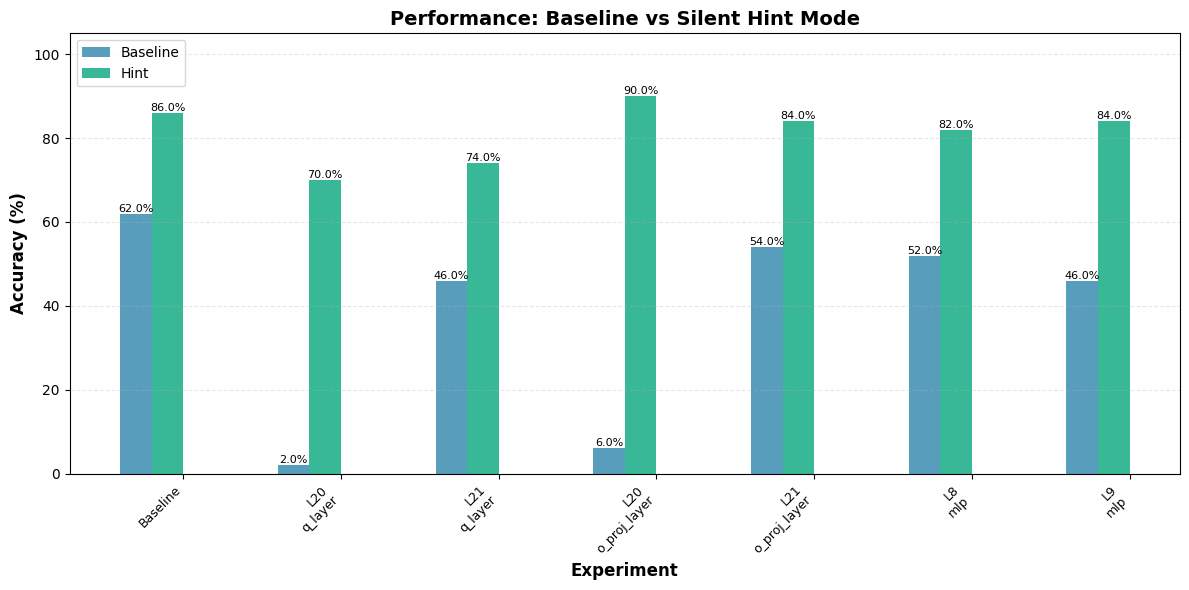

In [33]:
# ============================================================================
# VISUALIZATION: Baseline vs Silent Hint Modes
# ============================================================================

import matplotlib.pyplot as plt
import numpy as np

# # Load baseline if it exists and add to results for comparison
# baseline_file = os.path.join(OUTPUT_FOLDER, "baseline.jsonl")
# if os.path.exists(baseline_file):
#     print(f"Loading baseline results from {baseline_file}")
#     results_with_baseline = [(None, None, "none", baseline_file)] + results
# else:
#     print(f"Baseline file not found at {baseline_file}")
#     print("Run baseline experiment first by adding (None, None, 'none') to EXPERIMENTS")
#     results_with_baseline = results

def visualize_performance(results):
    """Visualize baseline vs silent hint modes across all experiments"""
    # Load all data
    exp_data = []
    exp_labels = []
    
    for layer_idx, head_idx, ablation_mode, output_file in results:
        data = []
        with open(output_file, "r") as f:
            for line in f:
                data.append(json.loads(line))
        df = pd.DataFrame(data)
        
        # Calculate accuracies
        baseline_df = df[df["mode"] == "baseline"]
        hint_correct_df = df[df["mode"] == "hint_correct_silent"]
        
        baseline_acc = baseline_df["is_correct"].sum() / len(baseline_df) * 100
        hint_correct_acc = hint_correct_df["is_correct"].sum() / len(hint_correct_df) * 100
        
        # Build experiment label
        if ablation_mode == "none":
            label = "Baseline"
        elif head_idx is not None:
            label = f"L{layer_idx}H{head_idx}\n{ablation_mode}"
        else:
            label = f"L{layer_idx}\n{ablation_mode}"
        
        exp_data.append({
            "baseline": baseline_acc,
            "hint_correct": hint_correct_acc,
        })
        exp_labels.append(label)
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(max(12, len(results) * 0.8), 6))
    
    x = np.arange(len(exp_labels))
    width = 0.2
    
    bars1 = ax.bar(x - 1.5*width, [d["baseline"] for d in exp_data], width, 
                    label="Baseline", color="#2E86AB", alpha=0.8)
    bars2 = ax.bar(x - 0.5*width, [d["hint_correct"] for d in exp_data], width,
                    label="Hint", color="#06A77D", alpha=0.8)
    
    ax.set_xlabel("Experiment", fontsize=12, fontweight="bold")
    ax.set_ylabel("Accuracy (%)", fontsize=12, fontweight="bold")
    ax.set_title("Performance: Baseline vs Silent Hint Mode", fontsize=14, fontweight="bold")
    ax.set_xticks(x)
    ax.set_xticklabels(exp_labels, rotation=45, ha="right", fontsize=9)
    ax.legend(loc="upper left", fontsize=10)
    ax.grid(axis="y", alpha=0.3, linestyle="--")
    ax.set_ylim([0, 105])
    
    # Add value labels on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.show()

visualize_performance(results)